# Potato length traj 600

I'm done with naming notebooks!!!

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from scipy.stats import norm

np.random.seed(69696969)

# Data Generation from Wiener Velocity Profile

Because this is the simplest case!

Text(0.5, 1.0, 'Position Profiles')

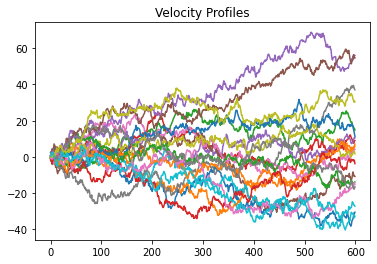

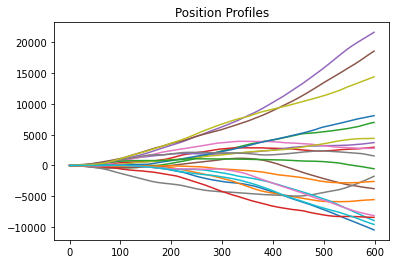

In [2]:
num_of_trajs = 200
length_of_trajs = 600
v_profiles = np.zeros((num_of_trajs, length_of_trajs))
x_profiles = np.zeros((num_of_trajs, length_of_trajs))
for i in range(num_of_trajs):
    a_profile = norm.rvs(scale=1, size=length_of_trajs)
    v_profiles[i,:] = np.cumsum(a_profile)
    x_profiles[i,:] = np.cumsum(v_profiles[i,:])
# Plot some sample v profiles and x profiles
trajs_to_plot = np.random.choice(num_of_trajs, 20)
plt.figure()
for i in trajs_to_plot:
    plt.plot(v_profiles[i,:])
plt.title('Velocity Profiles')
plt.figure()
for i in trajs_to_plot:
    plt.plot(x_profiles[i,:])
plt.title('Position Profiles')

# Find the Numerical FPCA

And let's call this basis NECTARINE.

In [3]:
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCA

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Text(0.5, 1.0, 'Numerical FPCA basis of Position Profiles')

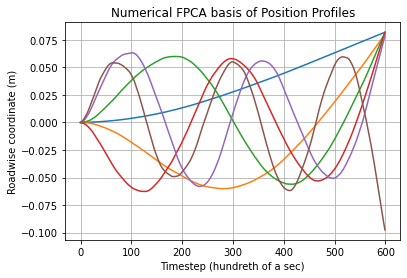

In [4]:
fdgrx = skfda.FDataGrid(x_profiles, np.arange(x_profiles.shape[1]))
fdgrv = skfda.FDataGrid(x_profiles, np.arange(x_profiles.shape[1]))
fpcax = FPCA(n_components=6)
fpcax.fit(fdgrx)
fpcax.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.title('Numerical FPCA basis of Position Profiles')

Get the covariance matrix, eigenvalues and eigenvectors

In [5]:
covx = fdgrx.cov().data_matrix
covx = covx.reshape(covx.shape[1:3])
evalx, evecx = np.linalg.eig(covx)
evalx = np.real(evalx)

Text(0.5, 1.0, 'Covariance matrix illustration')

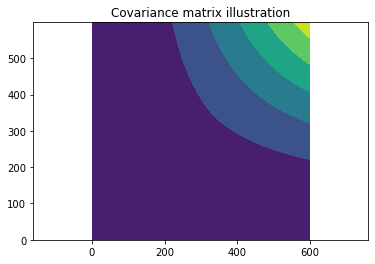

In [6]:
plt.contourf(covx)
plt.axis('equal')
plt.title('Covariance matrix illustration')

The eigenvalues ratio of x:

[9.74707499e-01 2.10622521e-02 2.89145510e-03 7.62691518e-04
 2.90718318e-04]


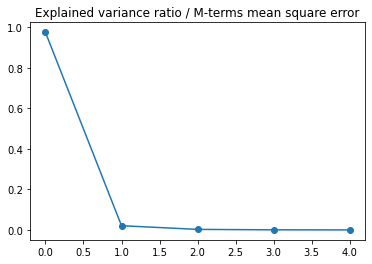

In [7]:
plt.plot(evalx[:5]/np.sum(evalx), '-o')
plt.title('Explained variance ratio / M-terms mean square error')
print(evalx[:5]/np.sum(evalx))

# Approximation of the Wiener process and its Integration

First we confirm the expansion of the Wiener process: $v(t) = \sum A_k \sqrt{2} cos((k-\frac{1}{2}\pi t))$ where $A_k$ follows a Gaussian random variable with variance $\frac{1}{((k-1/2)\pi)^2}$.

Text(0.5, 1.0, 'Reconstructed velocity profiles from 100 terms of expansion\nWithout restriction of time')

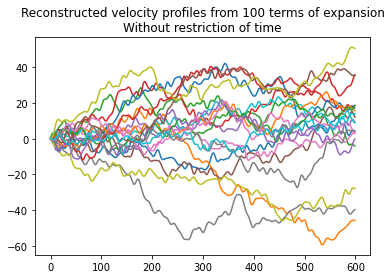

In [8]:
wiener = np.zeros((num_of_trajs, length_of_trajs))
wiener_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
for k in range(wiener_terms):
    for i in range(num_of_trajs):
        Ak = norm.rvs(scale=1/((k+0.5)*np.pi))
        wiener[i,:] += np.sqrt(length_of_trajs) * Ak * np.sqrt(2) * np.sin((k+0.5)*np.pi*t)
for i in trajs_to_plot:
    plt.plot(wiener[i,:])
plt.title('Reconstructed velocity profiles from {:d} terms of expansion\nWithout restriction of time'.format(wiener_terms))

Compare this with the Wiener velocity profiles above, we confirm the expansion of Wiener process by sine functions. Now let us restrict $t$ to $[0,1]$, without any loss of generality. As a result, we don't have to multiply each term with $\sqrt{N}$ - the length of the trajectory.

Text(0.5, 1.0, 'Reconstructed velocity profiles from 100 terms of expansion\nWith time restricted to [0,1]')

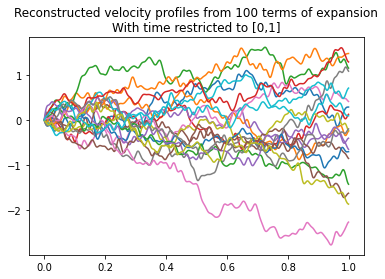

In [9]:
wiener = np.zeros((num_of_trajs, length_of_trajs))
wiener_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
for k in range(wiener_terms):
    for i in range(num_of_trajs):
        Ak = norm.rvs(scale=1/((k+0.5)*np.pi))
        wiener[i,:] += Ak * np.sqrt(2) * np.sin((k+0.5)*np.pi*t)
for i in trajs_to_plot:
    plt.plot(t, wiener[i,:])
plt.title('Reconstructed velocity profiles from {:d} terms of expansion\nWith time restricted to [0,1]'.format(wiener_terms))

We will try to construct the position profiles from $A_k$ and cosine: $x(t) = \sum_{k=1}^{+\infty} \frac{-\sqrt{2} A_k}{(k-1/2)\pi} (cos ((k-1/2)\pi t)-1)$.

Text(0.5, 1.0, 'Reconstructed position profiles from 100 terms of expansion\nWith time restricted to [0,1]')

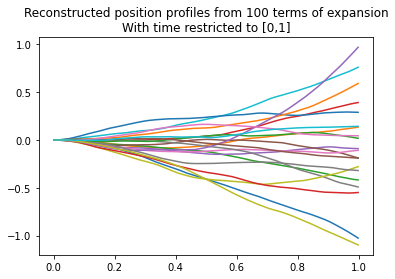

In [10]:
wienerint = np.zeros((num_of_trajs, length_of_trajs))
wienerint_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
# Generate Ak and Lambda
Ak = np.zeros((num_of_trajs, wienerint_terms))
Lamda = np.zeros((num_of_trajs,))
for k in range(wienerint_terms):
    for i in range(num_of_trajs):
        Ak[i,k] = norm.rvs(scale=1/((k+0.5)*np.pi))
        Lamda[i] += np.sqrt(2) * Ak[i,k] / ((k+0.5) * np.pi)
# Construct the position profiles
for i in range(num_of_trajs):
    for k in range(wienerint_terms):
        Aks = Ak[i,k]
        Lambd = Lamda[i]
        # wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi)) + (-1)**(k) * Lambd * 4./(np.pi * (2*k+1)) * np.cos((k+0.5)*np.pi*t)
        wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi)) * (np.cos((k+0.5)*np.pi*t)-1)
for i in trajs_to_plot:
    plt.plot(t, wienerint[i,:])
plt.title('Reconstructed position profiles from {:d} terms of expansion\nWith time restricted to [0,1]'.format(wiener_terms))

Reconstruction of $1(t)$ in the odd cosine basis:

Text(0.5, 1.0, 'Expansion of $1(t)$ in 10 terms')

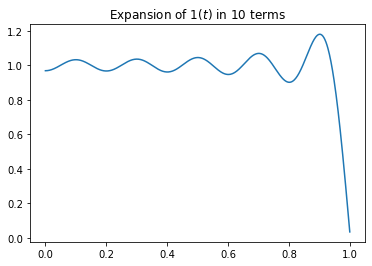

In [11]:
one_t = np.zeros((length_of_trajs))
one_terms = 10
t = np.arange(length_of_trajs)/length_of_trajs
for k in range(one_terms):
    one_t += 4/(np.pi) * 1/(2*k + 1) * ((-1)**k) * (np.cos((k+0.5)*np.pi*t))
plt.plot(t, one_t)
plt.title("Expansion of $1(t)$ in {:d} terms".format(one_terms))

So the expansion seems correct, but note the strong attenuation near $t=1$.

Which will also be equal to:

$ = \sum_{k=1}^{+\infty} \left( \frac{-\sqrt{2} A_k}{(k-1/2)\pi} + (-1)^{k+1} \Lambda \frac{4}{\pi} \frac{1}{2k-1} \right) cos ((k-1/2)\pi t)$ 

Text(0.5, 1.0, 'Reconstructed position profiles from 100 terms of expansion\nWith time restricted to [0,1]')

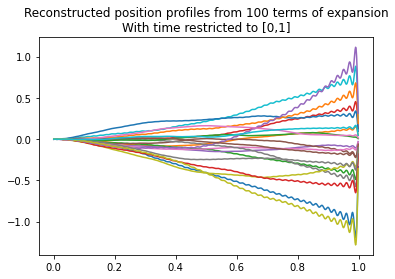

In [12]:
wienerint = np.zeros((num_of_trajs, length_of_trajs))
wienerint_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
# Generate Ak and Lambda
# Ak = np.zeros((num_of_trajs, wienerint_terms))
Lamda = np.zeros((num_of_trajs,))
for k in range(wienerint_terms):
    for i in range(num_of_trajs):
        # Ak[i,k] = norm.rvs(scale=1/((k+0.5)*np.pi)) # i: traj index, k: component index
        Lamda[i] += np.sqrt(2) * Ak[i,k] / ((k+0.5) * np.pi)
# Construct the position profiles
for i in range(num_of_trajs):
    for k in range(wienerint_terms):
        Aks = Ak[i,k]
        Lambd = Lamda[i]
        wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi) + (-1)**(k) * Lambd * 4./(np.pi * (2*k+1))) * np.cos((k+0.5)*np.pi*t)
        # wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi)) * (np.cos((k+0.5)*np.pi*t)-1)
for i in trajs_to_plot:
    plt.plot(t, wienerint[i,:])
plt.title('Reconstructed position profiles from {:d} terms of expansion\nWith time restricted to [0,1]'.format(wiener_terms))

It seems that the approximation works, but we don't know for sure whether the approximation is reasonable. 

# The Transform Coefficient Covariance Matrix

Next, we verify the formula for the covariance matrix of the Transform Coefficient Covariance. We hope that this covariance matrix, when stripped off the off-diagonal elements, will reasonably approximate the covariance matrix, which yields hope that the KLT and OCT are asymptotically equivalent.

**Numerical** approximation of the TCV:

In [13]:
CNcn = np.zeros((wienerint_terms, wienerint_terms))
for k in range(wienerint_terms):
    for s in range(wienerint_terms):
        coeffs_k = (-np.sqrt(2) * Ak[:,k] / ((k+0.5)*np.pi) + (-1)**(k) * Lambd * 4./(np.pi * (2*k+1)))
        coeffs_s = (-np.sqrt(2) * Ak[:,s] / ((s+0.5)*np.pi) + (-1)**(s) * Lambd * 4./(np.pi * (2*s+1)))
        CNcn[k,s] = np.average(coeffs_k * coeffs_s)

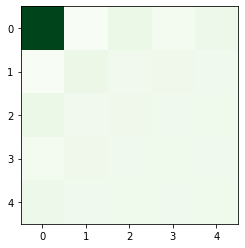

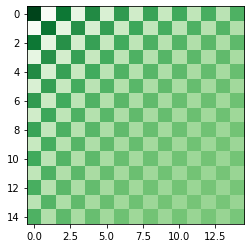

In [14]:
plt.figure()
plt.imshow(CNcn[:5,:5], cmap='Greens')
plt.figure()
plt.imshow(CNcn[5:20,5:20], cmap='Greens')

In [15]:
def delta(n,m):
    return 1 if n==m else 0

In [16]:
fourth_order_term = 0
for i in range(wienerint_terms):
    fourth_order_term += 1/((i+0.5)**4)
print('Fourth order term converges to {}'.format(fourth_order_term))

Fourth order term converges to 16.234848172350404


In [17]:
CNc = np.zeros((wienerint_terms, wienerint_terms))
for n in range(wienerint_terms):
    for m in range(wienerint_terms):
        # Note that we have discarded the fourth order term. 
        CNc[n,m] = 1/(((np.pi)**2) * (n+0.5) * (m+0.5)) * ((1 * delta(n,m) / (((np.pi)**2) * ((n+0.5)**2))) + 2 * (((-1)**(m)) / (((np.pi)**3) * ((n+0.5)**3)) + ((-1)**(n)) / (((np.pi)**3) * ((m+0.5)**3))))

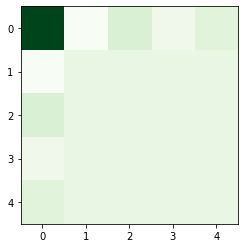

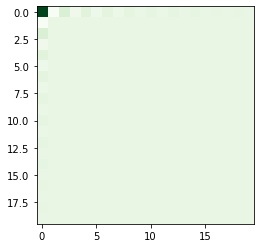

In [18]:
plt.figure()
plt.imshow(CNc[:5,:5], cmap='Greens')
plt.figure()
plt.imshow(CNc[:20,:20], cmap='Greens')

In essence, the top-left elements of the covariance matrix dominates rather than the main-diagonal. Hence, because of the presence of $\Lambda$, the main diagonal won't dominate all off-diagonal elements. Without $\Lambda$, it is easy to conclude that the OCT coincides with the KLT.

Here is a shameless effort to calculate the eigenvectors of the above covariance matrix:

In [19]:
eigvalCNc, eigvecCNc = np.linalg.eig(CNc) # the analytical version
eigvalCNcn, eigvecCNcn = np.linalg.eig(CNcn) # the numerical version

## Eigenvectors of the Transform Coefficients

This is the **eigenvectors of the analytical** covariance matrix:

KLT 1 lnr cmbn forml: [-0.98665837  0.11049217 -0.06945118  0.04901189 -0.03829476]
KLT 2 lnr cmbn forml: [-0.16278931 -0.67046015  0.40945376 -0.30180422  0.23350462]
KLT 3 lnr cmbn forml: [-3.62602521e-04  7.30710389e-01  4.56226568e-01 -2.67811265e-01
  1.99131849e-01]
KLT 4 lnr cmbn forml: [ 0.00217109  0.06328707 -0.78121888 -0.41581582  0.23132227]
KLT 5 lnr cmbn forml: [ 5.88533081e-06  1.65767761e-02 -8.89598036e-02  8.04558167e-01
  3.96597811e-01]
KLT 6 lnr cmbn forml: [-2.43934503e-04 -6.62868390e-03  3.00309028e-02 -1.10135373e-01
  8.21433687e-01]
KLT 7 lnr cmbn forml: [ 2.06332756e-06  2.98107212e-03 -1.36125098e-02  4.21755150e-02
 -1.22776316e-01]
KLT 8 lnr cmbn forml: [ 6.02132349e-05  1.63551379e-03 -7.02982824e-03  2.08612679e-02
 -5.07368884e-02]
KLT 9 lnr cmbn forml: [ 8.68717657e-07  9.12629591e-04 -4.07505897e-03  1.16681752e-02
 -2.66789145e-02]
KLT 10 lnr cmbn forml: [ 2.14661319e-05  5.85802166e-04 -2.49198290e-03  7.12956329e-03
 -1.57293540e-02]


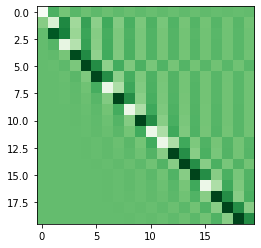

In [20]:
for i in range(10):
    print('KLT {:d} lnr cmbn forml: {}'.format(i+1, eigvecCNc[:5,i]))
plt.imshow(eigvecCNc.T, cmap='Greens')
plt.imshow(eigvecCNc[:20,:20].T, cmap='Greens')

Here is another visualization of how the eigenvectors combine the OCT basis vectors:

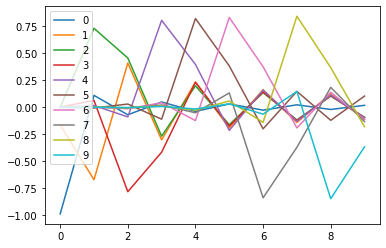

In [21]:
for i in range(10):
    plt.plot(eigvecCNc[:10,i], label=str(i))
plt.legend()

Energy portion shared by two main diagonals:

In [22]:
for i in range(20):
    print('Vec {}: argmax1: {}'.format(i, np.argmax(np.abs(eigvecCNc[:,i]))))
    print('Vec {}: {}'.format(i,np.sum(np.square(eigvecCNc[i-1:i+1,i]))/np.sum(np.square(eigvecCNc[:,i]))))

Vec 0: argmax1: 0
Vec 0: 0.0
Vec 1: argmax1: 1
Vec 1: 0.476017171510102
Vec 2: argmax1: 1
Vec 2: 0.7420803535170218
Vec 3: argmax1: 2
Vec 3: 0.7832057361431574
Vec 4: argmax1: 3
Vec 4: 0.8046036681869156
Vec 5: argmax1: 4
Vec 5: 0.8213306392562376
Vec 6: argmax1: 5
Vec 6: 0.8315463854413254
Vec 7: argmax1: 6
Vec 7: 0.8393447082702364
Vec 8: argmax1: 7
Vec 8: 0.8446366783610011
Vec 9: argmax1: 8
Vec 9: 0.8487624260509916
Vec 10: argmax1: 9
Vec 10: 0.8516851017675329
Vec 11: argmax1: 10
Vec 11: 0.8539703547027369
Vec 12: argmax1: 11
Vec 12: 0.8555877356690235
Vec 13: argmax1: 12
Vec 13: 0.8568198427485554
Vec 14: argmax1: 13
Vec 14: 0.8576421386608488
Vec 15: argmax1: 14
Vec 15: 0.8582132251060646
Vec 16: argmax1: 15
Vec 16: 0.8585139054480881
Vec 17: argmax1: 16
Vec 17: 0.8586410390365652
Vec 18: argmax1: 17
Vec 18: 0.8585797300527905
Vec 19: argmax1: 18
Vec 19: 0.8583930462403736


Hence it is expected that about 85% of the energy of the eigenvector will concentrate on the two main diagonals. Although this result is somewhat interesting, I still think the number is not high enough for the approximation effort of these eigenvectors.

And this is the **eigenvector of the numerical covariance matrix**:

KLT 1 lnr cmbn forml: [-0.99705512  0.05368094 -0.03262844]
KLT 2 lnr cmbn forml: [ 0.07524428  0.82189736 -0.32242614]
KLT 3 lnr cmbn forml: [-0.01474483  0.56050098  0.58704321]
KLT 4 lnr cmbn forml: [-5.79775791e-04  8.11312206e-02 -7.31455138e-01]
KLT 5 lnr cmbn forml: [ 0.00039306  0.02286974 -0.12173374]
KLT 6 lnr cmbn forml: [ 0.00081002 -0.01578366  0.0120532 ]
KLT 7 lnr cmbn forml: [ 0.00043163 -0.00451785 -0.01088492]
KLT 8 lnr cmbn forml: [ 0.00060427 -0.00569723 -0.00141978]
KLT 9 lnr cmbn forml: [ 0.00029473 -0.00229381  0.0129401 ]
KLT 10 lnr cmbn forml: [-0.00022013 -0.00475887 -0.00239477]


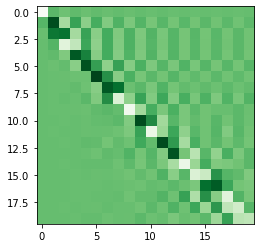

In [23]:
for i in range(10):
    print('KLT {:d} lnr cmbn forml: {}'.format(i+1, eigvecCNcn[:3,i]))
plt.imshow(eigvecCNcn.T, cmap='Greens')
plt.imshow(eigvecCNcn[:20,:20].T, cmap='Greens')

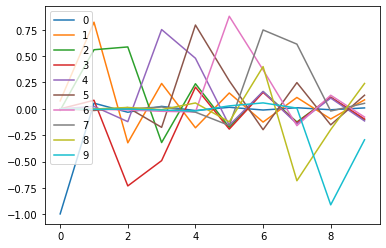

In [24]:
for i in range(10):
    plt.plot(eigvecCNcn[:10,i], label=str(i))
plt.legend()

**If the OCT coincides with KLT, we would expect a single diagonal matrix. But the above image shows that the eigenvectors form by "smuding together" two or three consecutive cosine basis**. This is strange and quite totally unexpected???

Let's see if we can get the KLT from combining these or not

In [25]:
klt_attempt = np.zeros((5,length_of_trajs))
t = np.arange(length_of_trajs)/length_of_trajs
max_oct_basis_to_add = 100
for i in range(klt_attempt.shape[0]):
    for j in range(max_oct_basis_to_add):
        klt_attempt[i,:] += eigvecCNc[j,i] * np.cos((j+0.5)*np.pi*t)

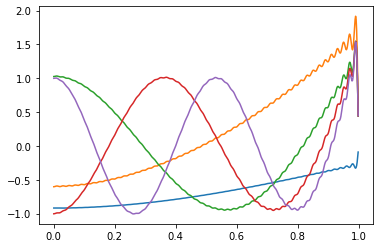

In [26]:
for i in range(klt_attempt.shape[0]):
    plt.plot(t, klt_attempt[i,:])

Seems like we retrieve the basis.

# Asymptotic Equivalence between OCT and KLT

The proof shows OCT and KLT should be equivalent when the block size $N$ is large (i.e., time range is wide). We will verify this experimentally.

Text(0.5, 1.0, 'OCT basis')

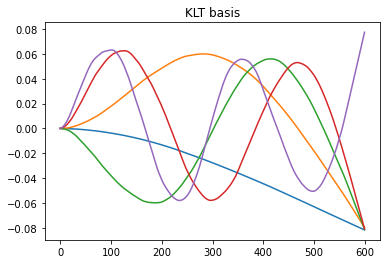

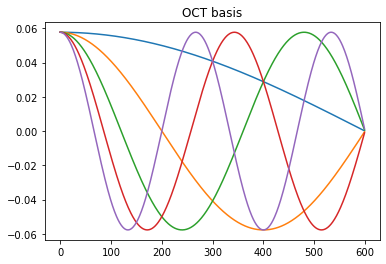

In [27]:
klt_basis = np.real(evecx.T) # each row is now an eigenvector
t = np.arange(length_of_trajs)/length_of_trajs
oct_basis = np.zeros(klt_basis.shape)
for i in range(klt_basis.shape[0]):
    oct_basis[i,:] = np.sqrt(2/(length_of_trajs)) * np.cos((i+0.5)*np.pi*t)
plt.figure()
for i in range(5):
    plt.plot(klt_basis[i,:])
plt.title('KLT basis')
plt.figure()
for i in range(5):
    plt.plot(oct_basis[i,:])
plt.title('OCT basis')

Let's approximate the average error when representing 100 trajectories in each basis: KLT and OCT

In [28]:
chosen_trajs = np.random.choice(num_of_trajs, size=100)
test_set = x_profiles[chosen_trajs,:]
klt_scores = test_set @ klt_basis.T
oct_scores = test_set @ oct_basis.T 

First we should check to make sure that the signal energy is well preserved in both basis.

In [29]:
signal_energy = np.sum(np.square(test_set), axis=1)
print('Max difference between KLT coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(klt_scores), axis=1) - np.sum(np.square(test_set), axis=1))))
print('Max difference between OCT coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(oct_scores), axis=1) - np.sum(np.square(test_set), axis=1))))

Max difference between KLT coeffs energy and signal energy: -0.8556280136108398
Max difference between OCT coeffs energy and signal energy: 6.962396621704102


Next, we try to compare the average approximation error with 1, 2, 3, ... components allowed to represent.

In [30]:
representation_error_of_klt = np.ones((10,))
representation_error_of_oct = np.ones((10,))
for max_components_allowed in range(1,10):
    tail_of_signal_klt = test_set - klt_scores[:,:max_components_allowed] @ klt_basis[:max_components_allowed,:]
    energy_of_signal_tail_klt = np.sum(np.square(tail_of_signal_klt), axis=1)
    proportion_of_energy_klt = energy_of_signal_tail_klt / signal_energy
    representation_error_of_klt[max_components_allowed] = np.average(proportion_of_energy_klt)

    tail_of_signal_oct = test_set - oct_scores[:,:max_components_allowed] @ oct_basis[:max_components_allowed,:]
    energy_of_signal_tail_oct = np.sum(np.square(tail_of_signal_oct), axis=1)
    proportion_of_energy_oct = energy_of_signal_tail_oct / signal_energy
    representation_error_of_oct[max_components_allowed] = np.average(proportion_of_energy_oct)

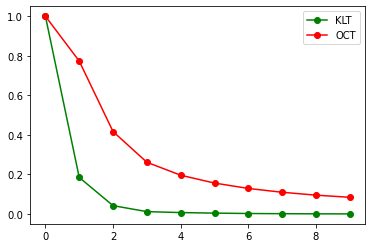

In [31]:
plt.plot(np.arange(0,10), representation_error_of_klt, 'g-o', label='KLT')
plt.plot(np.arange(0,10), representation_error_of_oct, 'r-o', label='OCT')
plt.legend()

So it seems that OCT and KLT are not asymptotic equivalent at all!